# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Read Data

In [2]:
train = pd.read_csv('my_train.csv')
test = pd.read_csv('my_test.csv')

## These two sets were created when I was pre-selecting features for regression. There were three types: categorical, numerical and tree specific. However, I will not use tree specific anymore because it did not add value and increases the model complexity significantly.

In [3]:
numerical = {'CSCOREB','DTI','MATDT','NO_UNITS','NUMBO','OLTV','ORIGRATE','ORIGTERM','ORIGUPB','REMMNTHS'}
categorical = 'CHNL_C','CHNL_R','FIRSTFLAG','OCCSTAT_P','OCCSTAT_S','PROP_CP','PROP_MH','PROP_PU','PROP_SF','PURPOSE_P','PURPOSE_R'

# Learnt from regression
- When I was about to finish regression part, I found that there are many outliers in the data causing my Mean Absolute Error was quite high; but the tuning process took almost 1 day to finish so I do not have enought time to redo it.
- For classificiation part, I will filter those outliers

In [4]:
percentiles = np.percentile(train['regression'],[25,75])
IQR = percentiles[1] - percentiles[0]
lower = percentiles[0] - 3*IQR # I used a very extreme case here
upper = percentiles[1] + 3*IQR

## The lower bound is actually negative so just need to control the upper bound

In [5]:
train_filter = train[train['regression'] <= upper].copy()

## Although I filtered with respect to NMONTHS, I believe this would also work for our classification

## Imbalanced Classes

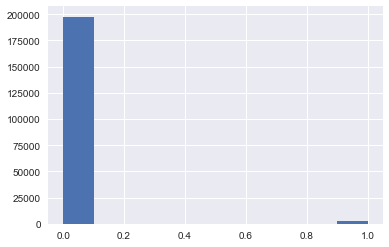

In [6]:
train['classfication'].astype(int).hist()

- Under-Sampling:
    - Advantages: It can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.
    - Disadvantages: It can discard potentially useful information which could be important for building rule classifiers. The sample chosen by random under sampling may be a biased sample. And it will not be an accurate representative of the population. Thereby, resulting in inaccurate results with the actual test data set.

- Over-Sampling:
    - Advantages: Unlike under sampling this method leads to no information loss. Outperforms under sampling
    - Disadvantages: It increases the likelihood of overfitting since it replicates the minority class events.
    
reference: https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/

### I will use Synthetic Minority Over-Sampling Technique (SMOTE) for Minority Class and Then Under-sampling for Majority Class
- Advantages
    - Mitigates the problem of overfitting caused by random oversampling as synthetic examples are generated rather than replication of instances
    - No loss of useful information
- Disadvantages
    - While generating synthetic examples SMOTE does not take into consideration neighboring examples from other classes. This can result in increase in overlapping of classes and can introduce additional noise
    - SMOTE is not very effective for high dimensional data
    
reference: https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/

In [34]:
#!pip install imblearn

In [35]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [36]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

In [37]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(train[[*categorical,*numerical]], train['classfication'])

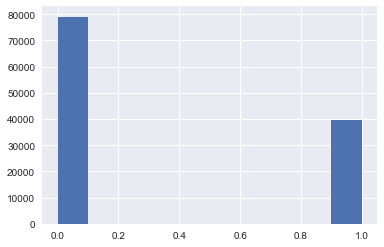

In [38]:
y.astype(int).hist()

In [40]:
balanced_data = X.join(y)

### Shuffling

In [42]:
balanced_data = balanced_data.sample(frac=1,random_state=0)

# FORECLOSED

- Logistic Regression
- Linear Discriminant Analysis
- Random Forests
- Neural Networks
- Best predictor (among the above four models) with Threshold (Probability) Tuning

## Summary List

In [107]:
Clf_Models = [] #Model Name
Clf_Models_Params = [] #Model's best parameters by cross-validation
Clf_Models_RA = [] #ROC_AUC by the model with best parameters

## I will first find the model with higest ROC_AUC and then look at its FPR and TPR and select the proper probability threshold.

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,KFold

In [45]:
k_fold = KFold(n_splits=5,shuffle=True, random_state = 0)

### For Logistic Regression, I only tuned "fit_intercept".

In [70]:
from sklearn.metrics import roc_auc_score,make_scorer

In [104]:
lr_imbalanced_grid = GridSearchCV(LogisticRegression(solver='newton-cg'),param_grid=dict(fit_intercept = [True,False]),cv = k_fold,\
                       scoring = 'roc_auc')
lr_grid = GridSearchCV(LogisticRegression(solver='newton-cg'),param_grid=dict(fit_intercept = [True,False]),cv = k_fold,\
                       scoring = 'roc_auc')

In [105]:
# Trained with orginial imbalanced data
lr_imbalanced_grid_res = lr_imbalanced_grid.fit(X = train[[*categorical,*numerical]], y = train['classfication'])

In [106]:
# Trained with balanced data
lr_grid_res = lr_grid.fit(X = balanced_data[[*categorical,*numerical]], y = balanced_data['classfication'])

### The model ROC_AUC was improved by only rebalancing the data! I will use balanced data for other models. (from around 0.85 to 0.87)

In [109]:
lr_grid_res.best_score_

0.8660963341897723

In [110]:
lr_imbalanced_grid_res.best_score_

0.8482916950771017

In [111]:
print("Best: %f using %s" % (lr_grid_res.best_score_, lr_grid_res.best_params_))
means = lr_grid_res.cv_results_['mean_test_score']
stds = lr_grid_res.cv_results_['std_test_score']
params = lr_grid_res.cv_results_['params']

Best: 0.866096 using {'fit_intercept': True}


In [112]:
Clf_Models.append('Logistic Regression')
Clf_Models_Params.append(lr_grid_res.best_params_)
Clf_Models_RA.append(lr_grid_res.best_score_)

## Linear Discriminant Analysis
I will tune solver and shrinkage

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [114]:
shrinks = [None,'auto']
solvers = ['svd', 'lsqr', 'eigen']
lda_param = dict(solver = solvers,shrinkage = shrinks)

In [118]:
lda_grid = GridSearchCV(LinearDiscriminantAnalysis(),param_grid = lda_param, cv = k_fold,\
                       scoring = 'roc_auc')

In [119]:
lda_grid_res = lda_grid.fit(X = balanced_data[[*categorical,*numerical]], y = balanced_data['classfication'])

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\micha\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 463, in fit
    raise NotImplementedError('shrinkage not supported')
NotImplementedError: shrinkage not supported

  FitFailedWarning)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\micha\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531

In [122]:
print("Best: %f using %s" % (lda_grid_res.best_score_, lda_grid_res.best_params_))
means = lda_grid_res.cv_results_['mean_test_score']
stds = lda_grid_res.cv_results_['std_test_score']
params = lda_grid_res.cv_results_['params']

Best: 0.864167 using {'shrinkage': None, 'solver': 'svd'}


In [123]:
Clf_Models.append('Linear Discriminant Analysis')
Clf_Models_Params.append(lda_grid_res.best_params_)
Clf_Models_RA.append(lda_grid_res.best_score_)

### For some hyperparameters of LDA, the algorithm did not converge. Also, the best score is worse than Logistic Regression.

## Random Forests
For Random Forests, I tuned no of trees, no of max_features, no of min_samples_leaf and no of min_samples_split

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [125]:
rf_n_trees = [20,30,50,100]
rf_max_features = ['auto',3,5,8,16]
rf_min_samples_leaf =  [2, 5, 10,20,30]
rf_min_samples_split = [10,20,50,60,100]

In [137]:
rf_param = dict(n_estimators = rf_n_trees,max_features = rf_max_features,min_samples_split = rf_min_samples_split,
                  min_samples_leaf = rf_min_samples_leaf )
rf_grid = GridSearchCV(RandomForestClassifier(random_state = 0), rf_param, cv = k_fold,
                       scoring = 'roc_auc',n_jobs=-1)

In [138]:
rf_grid_res = rf_grid.fit(X = balanced_data[[*categorical,*numerical]], y = balanced_data['classfication'])

In [135]:
print("Best: %f using %s" % (rf_grid_res.best_score_, rf_grid_res.best_params_))
means = rf_grid_res.cv_results_['mean_test_score']
stds = rf_grid_res.cv_results_['std_test_score']
params = rf_grid_res.cv_results_['params']

Best: 0.985213 using {'max_features': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 50}


### The ROC_AUC score is significantly improved by using Random Forest with parameters {'max_features': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 50}

In [136]:
Clf_Models.append('Random Forest')
Clf_Models_Params.append(rf_grid_res.best_params_)
Clf_Models_RA.append(rf_grid_res.best_score_)

## Neural Nets
I only Tune Batch Size and Number of Epochs due to the complexity (high dimension of hyperparameters) of Neural Nets.

In [146]:
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [154]:
input_no = balanced_data[[*categorical,*numerical]].shape[1]

In [155]:
def NN():
    # create model
    ann = Sequential()
    #First Hidden Layer
    ann.add(Dense(int(input_no/2), activation='relu', kernel_initializer='random_normal',\
                  input_dim= input_no))
    #Second Hidden Layer
    ann.add(Dense(int(input_dim/4), activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    ann.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    ann.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])

    return ann

In [161]:
np.random.seed(0)
# create model
model = KerasClassifier(build_fn=NN, verbose=0)
# define the grid search parameters
batch_size = [200,500,1000]
epochs = [30,50,80]
nn_param = dict(batch_size=batch_size, epochs=epochs)
nn_grid = GridSearchCV(model, nn_param, cv = k_fold,
                       scoring = 'roc_auc',n_jobs=-1)

In [162]:
nn_grid_res = nn_grid.fit(X = balanced_data[[*categorical,*numerical]], y = balanced_data['classfication'])

C:\Users\micha\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [164]:
nn_grid_res.best_score_

0.8819471858242949

## The main reason Neural Net is not better than Random Forest is that many hyperparameters were not tuned such as optimizer,  Learning Rate, Momentum, even the shape of the Network. I decided to use Random Forest since its ROC_AUC is almost 1 which is good enough so I did not further tune Neural Net.

In [165]:
print("Best: %f using %s" % (nn_grid_res.best_score_, nn_grid_res.best_params_))
means = nn_grid_res.cv_results_['mean_test_score']
stds = nn_grid_res.cv_results_['std_test_score']
params = nn_grid_res.cv_results_['params']

Best: 0.881947 using {'batch_size': 200, 'epochs': 50}


In [166]:
Clf_Models.append('Neural Net')
Clf_Models_Params.append(nn_grid_res.best_params_)
Clf_Models_RA.append(nn_grid_res.best_score_)

In [167]:
Clf_Result = pd.DataFrame(dict(Model = Clf_Models, Parameters = Clf_Models_Params, ROC_AUC = Clf_Models_RA))

In [168]:
Clf_Result

,Model,Parameters,ROC_AUC
0,Logistic Regression,{'fit_intercept': True},0.866096
1,Linear Discriminant Analysis,"{'shrinkage': None, 'solver': 'svd'}",0.864167
2,Random Forest,"{'max_features': 8, 'min_samples_leaf': 20, 'm...",0.985213
3,Neural Net,"{'batch_size': 200, 'epochs': 50}",0.881947


## Probability Threshold
Random Forest was the best predictor so I will use it only for Probability Threshold Tuning (FPR <= 50% while maximizing TPR)

In [172]:
Clf_Result.iloc[2,1]

{'max_features': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 50,
 'n_estimators': 50}

In [173]:
rf_best = RandomForestClassifier(n_estimators = 50, max_features = 8, min_samples_leaf = 20, min_samples_split = 50,\
                                random_state = 0)

In [174]:
rf_best_res = rf_best.fit(X = balanced_data[[*categorical,*numerical]], y = balanced_data['classfication'])

In [177]:
feature_importances = pd.DataFrame(data = rf_best_res.feature_importances_, index = [*categorical,*numerical])

### The most important features are quite consistent with regression's result except ordering difference. As I expected, the larger the number of NUMBO, the greater the chance of Forclosed! Indeed, NUMBO is the most important feature. Other features are also reasonable like CSCOREB (people with higher credit score are more likely to pay ealier).

In [251]:
feature_importances.sort_values(0,ascending=False).head()

,0
NUMBO,0.303970
CSCOREB,0.176431
OLTV,0.136445
MATDT,0.101499
REMMNTHS,0.092026


### Get In-Sample Predicted Probabilities

In [245]:
predicted_prob = rf_best_res.predict_proba(balanced_data[[*categorical,*numerical]])[:,1]

### Get ROC Curve

In [247]:
from sklearn.metrics import roc_curve,confusion_matrix

In [248]:
fpr, tpr, thresholds = roc_curve(balanced_data['classfication'], predicted_prob)

Model achieved almost 1 roc_auc score for In-Sample data.

In [253]:
roc_auc_score(balanced_data['classfication'], predicted_prob)

0.9922510311452016

In [254]:
tau_list = np.linspace(0,1,101)
FPR = []
TPR = []
for tau in tau_list:
    tn, fp, fn, tp = confusion_matrix(y_true = balanced_data['classfication'],\
                                      y_pred= predicted_prob > tau).ravel()
    FPR.append(fp/(fp+tn))
    TPR.append(tp/(tp+fn))

In [255]:
ROC = pd.DataFrame({'Tau': tau_list,'FPR': FPR, 'TPR': TPR})
ROC.set_index('Tau',inplace = True)

### Only look at ***False Positive Rate*** less or equal to 0.5

In [256]:
FPR_under_50 = ROC[ROC['FPR'] <= 0.5].copy()

In [257]:
Max_TPR = FPR_under_50[FPR_under_50['TPR'] == FPR_under_50['TPR'].max()].copy()

This model has around 48% FPR but with very high TPR

In [258]:
Max_TPR

,FPR,TPR
Tau,,
0.04,0.482611,0.999848


In [259]:
FPR_under_50.sort_values('TPR',ascending=False)

,FPR,TPR
Tau,,
0.04,0.482611,0.999848
0.05,0.439538,0.999595
0.06,0.402686,0.999342
0.07,0.369780,0.998988
0.08,0.341161,0.998457
...,...,...
0.96,0.000013,0.441713
0.97,0.000000,0.405468
0.98,0.000000,0.358980


## Summary

In [260]:
from sklearn.metrics import accuracy_score

In [261]:
accuracy_score(balanced_data['classfication'],predicted_prob > 0.04)

0.6782085978534874

In [262]:
roc_auc_score(balanced_data['classfication'],predicted_prob)

0.9922510311452016

### Although the accuracy of our model is not high, our purpose is to find the model with highest ***True Positive Rate*** while controlling the level of ***False Positive Rate***. Our best model is Random Forest with tuned hyperparameters {'max_features': 8, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 50} and probability threshold as 0.04 (Tau)

In [263]:
Max_TPR

,FPR,TPR
Tau,,
0.04,0.482611,0.999848


In [264]:
predictions = pd.read_csv('Regression_Predictions.csv')

In [265]:
predictions['FORCLOSED'] = rf_best_res.predict_proba(test[[*categorical,*numerical]])[:,1] > 0.04

In [267]:
predictions.to_csv('predictions.csv')